# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---


In [ ]:
#BASIC TOOLS
import pandas as pd                 #pandas library
import numpy as np                  #numpy library
import matplotlib.pyplot as plt    #plotting library
import random
import seaborn as sns
from scipy.stats import loguniform 

#CUSTOM LIBRARIES
import models
import utils

#PYTORCH
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
import torchvision
from torch.optim.lr_scheduler import ExponentialLR

#SKORCH
from skorch import NeuralNetClassifier, NeuralNet
from skorch.callbacks import LRScheduler, EarlyStopping
from skorch.dataset import CVSplit

#SKLEARN
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, RandomizedSearchCV, ShuffleSplit

#fixing a seed for reproducibility
np.random.seed(1)
torch.manual_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
sns.set(rc={'figure.figsize':(6,4)})

# Regression task

In [192]:
#load train and test set already splitted
train_df = pd.read_csv('regression_dataset/train_data.csv')
test_df  = pd.read_csv('regression_dataset/test_data.csv')

In [193]:
#first 5 entries of training dataframe
train_df.head(5)

,input,label
0,-4.787870,-1.216804
1,-3.509057,3.277581
2,-3.855373,2.621375
3,-4.083518,1.046088
4,-4.230588,1.228874


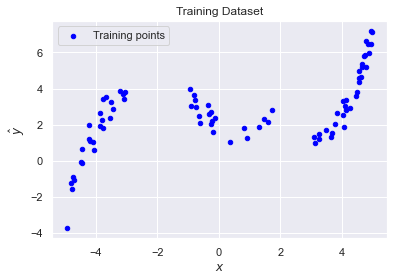

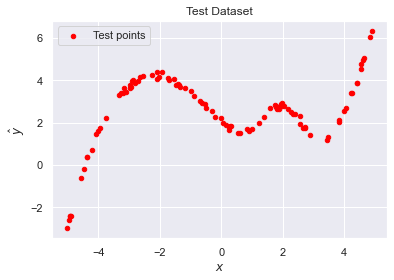

In [243]:
#plot the training points
train_df.plot(x = "input", y = "label", kind = "scatter", title = "Training Dataset", legend = True, label = "Training points", xlabel = '$x$', ylabel = '$\hat{y}$', color = 'blue')
plt.savefig('training_points.pdf')
test_df.plot(x = "input", y = "label", kind = "scatter", title = "Test Dataset", legend = True, label = "Test points", xlabel = '$x$', ylabel = '$\hat{y}$', color = 'red')
plt.savefig('test_points.pdf')

In [195]:
#subdivide the training in effective training 80% and validation 20%
train_df_temp = train_df.sample(frac = 0.8)
validation_df = train_df.drop(train_df_temp.index)
train_df      = train_df_temp

composed_transform = transforms.Compose([utils.ToTensor()])

#transform to tensor
train_dataset      = utils.CsvDataset(train_df,      transform = composed_transform)
validation_dataset = utils.CsvDataset(validation_df, transform = composed_transform)
test_dataset       = utils.CsvDataset(test_df,       transform = composed_transform)

In [196]:
#instantiate the dataloaders
train_dataloader      = DataLoader(train_dataset, 
                                   batch_size = 7, 
                                   shuffle = True, 
                                   num_workers = 0
                                   )
validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size = len(validation_dataset), 
                                   shuffle = True, 
                                   num_workers = 0
                                   )
test_dataloader       = DataLoader(test_dataset,  
                                   batch_size=len(test_dataset), 
                                   shuffle=False, 
                                   num_workers=0
                                   )

In [50]:
#network for the first simple and non-optimized model
net_par = {'Ninp':       1,
           'Nh1':        16,
           'Nh2':        16,
           'Nout':       1,
           'act_func':   nn.ReLU()
           }

net = models.FullyConnectedNeuralNetSimple(net_par)
net.to(device)

hyp_par = {'num_epochs': 2000,
           'device':     device,
           'loss_fn':    nn.L1Loss(),
           'opt':        optim.Adam(net.parameters(), lr=0.003)
           }

In [42]:
train_loss, val_loss = net.fit(train_dataloader, validation_dataloader, hyp_par)

100%|██████████| 2000/2000 [00:49<00:00, 40.41it/s]


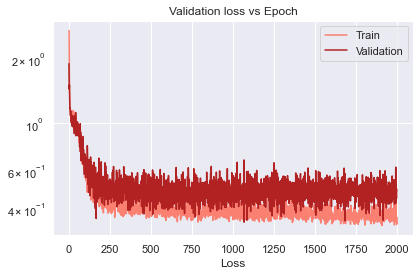

In [48]:
utils.PlotLoss(train_loss, 'Train')
utils.PlotLoss(val_loss, 'Validation')

In [49]:
#input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

#network output
net.eval()                   #switch for some specific layers/parts of the model that behave differently during training and inference
with torch.no_grad():        # turn off gradients computation
    y_vec = net(x_vec)

#convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

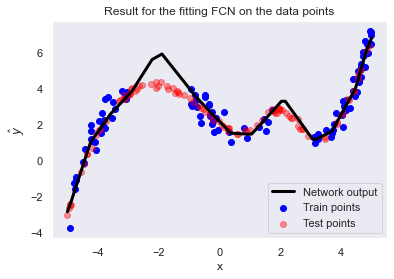

In [50]:
plt.plot(x_vec, y_vec, label='Network output', color='black',lw=3)

plt.scatter(train_df['input'],train_df['label'], label='Train points', color='blue')
plt.scatter(test_df['input'],test_df['label'], alpha=0.4, label='Test points', color='red')
plt.xlabel('x')
plt.ylabel(r'$\hat{y}$')
plt.grid()
plt.legend()
plt.title('Result for the fitting FCN on the data points')
plt.savefig('overfit_dummy_model.pdf')

## Grid search

In [7]:
def random_choice(dict):
    '''
    
    Selects at random a set of parameters from a given dictionary 'dict'
    
    '''
    par = {} 
    for key, value in dict.items():
        par[key]=random.choice(value)
    return par

def random_GS(grid, dataset):
    '''

    -> Performs a grid search over a grid of parameters
       and on a given dataset in input (the full training dataset, that
       will be automatically splitted in a KFold cross-validation fashion.) 

    Parameters:
    train_dl    - train DataLoader
    test_dl     - test DataLoader
    hyp_par     - other simulation hyperparameters:
                        num_epochs - number of epochs
                        device     - CPU or GPU (if possible)
                        opt        - optimizer
                        loss_fn    - loss function
    
    '''

    h_n = grid['net']           #selecting network hyperparameter
    h_l = grid['learning']      #selecting simulation hyperparameter

    #list with parameters of each model 
    net_params     = []
    #list with train loss of each model 
    train_loss_log = []
    #list with validation loss of each model 
    val_loss_log   = []
    
    #loop over n models
    for ii in range(h_l['n_models'][0]):

        print('Trying model number', ii+1)

        #choose parameters at random from the grid
        n_params = random_choice(h_n)
        l_params = random_choice(h_l)

        #total dictionary to append at the end
        total_params = {'net':n_params, 'learning':l_params}
        print(total_params)
        
        kf = KFold(h_l['folds'][0], shuffle=True)
       
        #np.array with train loss computed on each fold 
        train_loss_ff = np.zeros((h_l['folds'][0], h_l['num_epochs'][0]))
        #np.array with validation loss computed on each fold
        val_loss_ff   = np.zeros((h_l['folds'][0], h_l['num_epochs'][0]))
        
        #loop over the folds
        for ff, (ff_train, ff_validation) in enumerate(kf.split(dataset)):

            train_subsampler = SubsetRandomSampler(ff_train)
            valid_subsampler = SubsetRandomSampler(ff_validation)

            # define data loaders
            train_dataloader = DataLoader(dataset, batch_size=int(l_params['batch_size']), sampler=train_subsampler)
            validation_dataloader = DataLoader(dataset, batch_size=int(l_params['batch_size']), sampler=valid_subsampler)   

            net = models.FullyConnectedNeuralNet(n_params).to(l_params['device'])
            net.reset()
            #optimizer selection
            if   l_params['opt']=='SGD':
                optimizer = optim.SGD(net.parameters(), lr=l_params['lr'], momentum=0.9, weight_decay=l_params['reg'])
            elif l_params['opt']=='Adam':
                optimizer = optim.Adam(net.parameters(), lr=l_params['lr'], weight_decay=l_params['reg'])
            elif l_params['opt']=='RMSprop':
                optimizer = optim.RMSprop(net.parameters(), lr=l_params['lr'], weight_decay=l_params['reg'])

            #build the dictionary useful for net.fit
            hyp_par = {'num_epochs': l_params['num_epochs'],
                       'device':     l_params['device'],
                       'loss_fn':    nn.MSELoss(),
                       'opt':        optimizer
                    }

            train_loss, val_loss = net.fit(train_dataloader, validation_dataloader, hyp_par)

            train_loss_ff[ff] = train_loss
            val_loss_ff[ff] = val_loss

        train_loss_log.append(np.mean(train_loss_ff, 0))
        val_loss_log.append(np.mean(val_loss_ff, 0))
        net_params.append(total_params)
        print(np.mean(np.mean(train_loss_ff, 0)))
        
    return net_params, train_loss_log, val_loss_log

In [ ]:
#on each model sampled from the grid we perform a k=5 cross-validation
grid = {'net':    {'Ninp':       [1],
                   'Nh1':        [4, 8, 16],
                   'Nh2':        [4, 8, 16],
                   'Nh3':        [4, 8, 16],
                   'Nout':       [1],
                   'act_func':   [nn.ReLU(), nn.LeakyReLU()]
                   },

       'learning':{'n_models':   [400],
                   'batch_size': [5,7,9,10],
                   'num_epochs': [300],
                   'folds':      [5],
                   'device':     [device],
                   'opt':        ['SGD', 'Adam', 'RMSprop'],
                   'lr':         loguniform.rvs(1e-4, 1e-1, size=100),
                   'reg':        loguniform.rvs(1e-5, 1e-1, size=100)
                   }
       }

#load again the train set since we don't need the split in train and validation
train_df = pd.read_csv('regression_dataset/train_data.csv')

train_dataset = utils.CsvDataset(train_df, transform=composed_transform)

#uncomment to run the cell
#net_params, train_losses, val_losses = random_GS(grid, train_dataset)

## Results

In [467]:
avg_val_loss = [np.mean(vl) for vl in val_losses]
best_n_l_par = net_params[np.where(avg_val_loss==np.sort(avg_val_loss)[:10][0])[0][0]]

print('Minimum average validation losses (top 10):', np.sort(avg_val_loss)[:10])
print('Best parameter:', best_n_l_par)

Minimum average validation losses (top 10): [0.58352626 0.59993234 0.61293288 0.63547924 0.63965571 0.64540086
 0.66161008 0.66243439 0.6643499  0.66693631]
Best parameter: {'net': {'Ninp': 1, 'Nh1': 16, 'Nh2': 16, 'Nh3': 16, 'Nout': 1, 'drop_prob': 0.0008194254573277526, 'act_func': ReLU()}, 'learning': {'n_models': 400, 'batch_size': 10, 'num_epochs': 300, 'folds': 5, 'device': device(type='cpu'), 'opt': 'Adam', 'lr': 0.012010348166177666, 'reg': 0.0004419953086109655}}


In [530]:
#train a model built on the best parameters, on more epochs 
net = models.FullyConnectedNeuralNet(best_n_l_par['net']).to(best_n_l_par['learning']['device'])
#reset network weights
net.reset()

if   best_n_l_par['learning']['opt']=='SGD':
    optimizer = optim.SGD(net.parameters(), 
                           lr=best_n_l_par['learning']['lr'], 
                           momentum=0.9, 
                           weight_decay=best_n_l_par['learning']['reg']
                           )
elif best_n_l_par['learning']['opt']=='Adam':
    optimizer = optim.Adam(net.parameters(),
                           lr = best_n_l_par['learning']['lr'], 
                           weight_decay = best_n_l_par['learning']['reg']
                           )
elif best_n_l_par['learning']['opt']=='RMSprop':
    optimizer = optim.RMSprop(net.parameters(),
                              lr = best_n_l_par['learning']['lr'], 
                              weight_decay = best_n_l_par['learning']['reg']
                              )
                              
hyp_par = {'num_epochs': 500,
           'device':     best_n_l_par['learning']['device'],
           'loss_fn':    nn.L1Loss(),
           'opt':        optimizer
           }

In [531]:
#register initialized weights for the final plot
w_h1_init=net.h1.weight.detach().cpu().numpy().flatten()
w_h2_init=net.h2.weight.detach().cpu().numpy().flatten()
w_h3_init=net.h3.weight.detach().cpu().numpy().flatten()
w_out_init=net.out.weight.detach().cpu().numpy().flatten()

The stage is set! We now load again the data and perform the fitting.

In [532]:
#load train and test set already splitted
train_df = pd.read_csv('regression_dataset/train_data.csv')


train_df_temp = train_df.sample(frac = 0.8)
validation_df = train_df.drop(train_df_temp.index)
train_df      = train_df_temp


composed_transform = transforms.Compose([utils.ToTensor()])

train_dataset      = utils.CsvDataset(train_df,      transform=composed_transform)
validation_dataset = utils.CsvDataset(validation_df, transform=composed_transform)

train_dataloader = DataLoader(train_dataset, 
                                batch_size=best_n_l_par['learning']['batch_size'], 
                                shuffle=True,
                                num_workers=0
                                )
validation_dataloader = DataLoader(validation_dataset, 
                                   batch_size = len(validation_dataset), 
                                   shuffle = True, 
                                   num_workers = 0
                                   )

In [533]:
train_loss_best, val_loss_best = net.fit(train_dataloader, validation_dataloader, hyp_par)

100%|██████████| 500/500 [00:16<00:00, 29.44it/s]


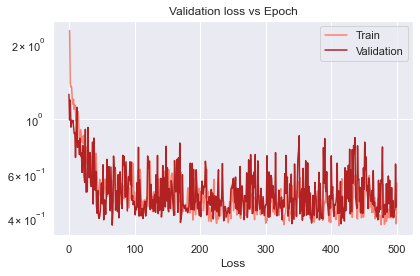

In [534]:
utils.PlotLoss(train_loss_best, 'Train')
utils.PlotLoss(val_loss_best, 'Validation')

In [535]:
# Input vector
x_vec = torch.linspace(-5,5,1000)
x_vec = x_vec.to(device)
x_vec = x_vec.unsqueeze(-1)  # Adding a dimension to the input vector

net.eval()
with torch.no_grad(): # turn off gradients computation
    y_vec = net(x_vec)

# Convert x_vec and y_vec to numpy one dimensional arrays
x_vec = x_vec.squeeze().cpu().numpy()
y_vec = y_vec.squeeze().cpu().numpy()

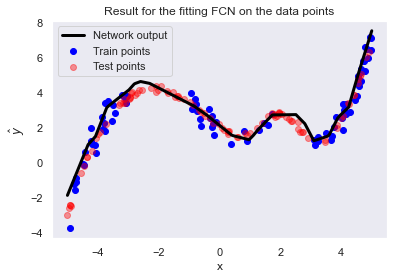

In [536]:
plt.plot(x_vec, y_vec, label='Network output', color='black',lw=3)

plt.scatter(train_df['input'],train_df['label'], label='Train points', color='blue')
plt.scatter(test_df['input'],test_df['label'], alpha=0.4, label='Test points', color='red')
plt.xlabel('x')
plt.ylabel(r'$\hat{y}$')
plt.grid()
plt.legend()
plt.title('Result for the fitting FCN on the data points')
plt.savefig('fit_complex_model.pdf')

## Layer weights

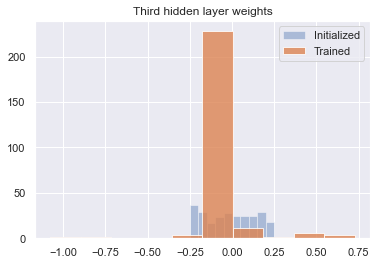

In [480]:
# plt.hist(net.h1.weight.detach().cpu().numpy().flatten())
# plt.savefig('first_layer.pdf')
# plt.hist(net.h2.weight.detach().cpu().numpy().flatten())
# plt.savefig('second_layer.pdf')
# plt.hist(net.h3.weight.detach().cpu().numpy().flatten())
# plt.savefig('third_layer.pdf')
plt.hist(w_h3_init, alpha=0.4, label='Initialized')
plt.hist(net.h3.weight.detach().cpu().numpy().flatten(), alpha=0.8, label='Trained')
plt.title('Third hidden layer weights')
plt.legend()
plt.savefig('third_layer.pdf')

## Activation profiles

In [537]:
activation = {}

def getActivation(name):
    '''
    
    Retrieve activations to for the activation profiles
    
    '''
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [538]:
#register the activations for each layer
h1 = net.h1.register_forward_hook(getActivation('h1'))
h2 = net.h2.register_forward_hook(getActivation('h2'))
h3 = net.h3.register_forward_hook(getActivation('h3'))
out = net.out.register_forward_hook(getActivation('out'))

In [539]:
x = np.linspace(-5, 5, 1000, dtype=np.float32)
y = net(torch.tensor(x).unsqueeze(1))

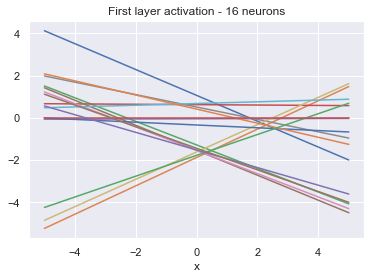

In [590]:
plt.plot(x,activation['h1'].detach())
plt.title('First layer activation - 16 neurons')
plt.xlabel('x')
plt.savefig('act_profile_1st.pdf')

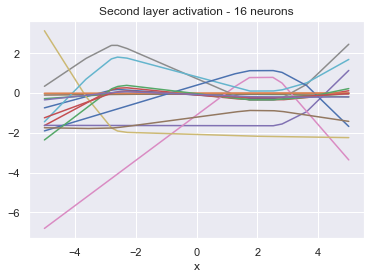

In [589]:
plt.plot(x,activation['h2'].detach())
plt.title('Second layer activation - 16 neurons')
plt.xlabel('x')
plt.savefig('act_profile_2nd.pdf')

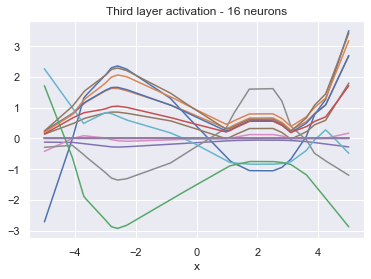

In [591]:
plt.plot(x,activation['h3'].detach())
plt.title('Third layer activation - 16 neurons')
plt.xlabel('x')
plt.savefig('act_profile_3rd.pdf')

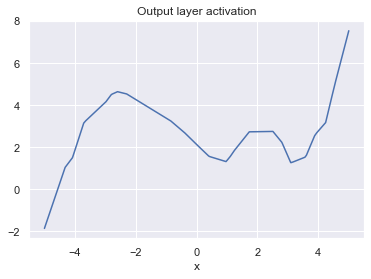

In [592]:
plt.plot(x,activation['out'].detach())
plt.title('Output layer activation')
plt.xlabel('x')
plt.savefig('act_profile_out.pdf')

# Classification task

## Guidelines

* The goal is to train a neural network that maps an input image (from fashionMNIST) to one of ten classes (multi-class classification problem with mutually exclusive classes).
* Define a proper loss (e.g. [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss))
* Also here, consider to create a validation set from you training data, or use a k-fold cross-validation strategy.
* Pay attention to the shape, data type and output values range. If needed, modify them accordingly to your implementation (read carefully the documentation of the layers that you use, e.g. [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)).
* Explore different optimizers, acivation functions, network architectures. Analyze the effect of different regularization methods, such as dropout layers, random transformations (image rotation, scaling, add noise...) or L2 regularization (weight decay).

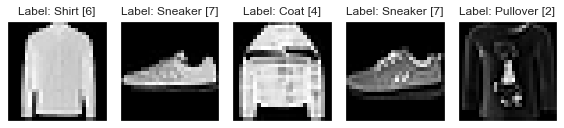

In [20]:
#download the dataset
train_dataset_plot = torchvision.datasets.FashionMNIST('classifier_data', train=True,  download=True)

label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset_plot)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig('FashionMNIST_samples.pdf')

In [21]:
#transformation to reduce overfitting and increase generalization capabilities of the model
train_transf   = transforms.Compose([transforms.RandomHorizontalFlip(), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize((0.1307,), (0.3081,)),
                                     transforms.RandomCrop(28, padding=4), 
                                     transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value="random", inplace=False,)])

plain_transf   = transforms.Compose([transforms.ToTensor(), 
                                     transforms.Normalize((0.1307,), (0.3081,))])                                                

train_dataset = torchvision.datasets.FashionMNIST('classifier_data', train=True,  download=True, transform=train_transf)
test_dataset  = torchvision.datasets.FashionMNIST('classifier_data', train=False, download=True, transform=plain_transf)

train_set_array = train_dataset.data.type(torch.float32).reshape(60000,1,28,28)
train_set_label = train_dataset.targets.type(torch.int64).reshape(60000)
test_set_array  = test_dataset.data.numpy().astype(np.float32)
test_set_label  = test_dataset.targets.numpy().astype(np.float32)

In [ ]:
label_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img[0]), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.savefig('FashionMNIST_samples_augmented.pdf')

In [28]:
net = NeuralNetClassifier(module                        = models.ConvolutionalNet,
                          max_epochs                    = 10,
                          criterion                     = nn.CrossEntropyLoss,
                          module__prob_drop             = 0.4,
                          module__prob_drop2            = 0.2,
                          module__act_func              = nn.ReLU(),
                          module__xavier                = False,
                          batch_size                    = 64,
                          train_split                   = CVSplit(0.2),
                          optimizer                     = optim.Adam,
                          lr                            = 0.001,
                          optimizer__weight_decay       = 0.01)

params = {"module__prob_drop"              : (loguniform.rvs(.05, .65,  size = 10)),
          "module__prob_drop2"             : (loguniform.rvs(.05, .65,  size = 10)),
          "module__act_func"               : [nn.ReLU(), nn.LeakyReLU()],
          "batch_size"                     : [64,128],
          "lr"                             : loguniform.rvs(1e-4, 1e-2, size = 20),
          'optimizer'                      : [optim.Adam],
          'optimizer__weight_decay'        : loguniform.rvs(1e-5, 1e-2, size = 20) }

gs = RandomizedSearchCV(net, 
                        params, 
                        n_iter = 100, 
                        cv = ShuffleSplit(n_splits = 1, test_size = 0.2), 
                        scoring = 'accuracy', 
                        verbose = 2)

In [ ]:
#gs.fit(train_set_array, train_set_label)

In [30]:
print(gs.best_score_, gs.best_params_)

0.9054166666666666 {'optimizer__weight_decay': 0.00037419213241558796, 'optimizer': <class 'torch.optim.adam.Adam'>, 'module__prob_drop2': 0.05361588319174629, 'module__prob_drop': 0.10186681128893188, 'module__act_func': ReLU(), 'lr': 0.0002453741863580673, 'batch_size': 64}


Final model train

In [31]:
best_net = NeuralNetClassifier(
                        module                       = models.ConvolutionalNet,
                        max_epochs                   = 30,
                        criterion                    = nn.CrossEntropyLoss,
                        module__prob_drop            = gs.best_params_['module__prob_drop'],
                        module__prob_drop2           = gs.best_params_['module__prob_drop2'],
                        module__act_func             = gs.best_params_['module__act_func'],
                        module__xavier               = False,
                        batch_size                   = gs.best_params_['batch_size'],
                        train_split                  = CVSplit(0.2),
                        optimizer                    = gs.best_params_['optimizer'],
                        callbacks                    = [EarlyStopping(patience = 10)],
                        lr                           = gs.best_params_['lr'],
                        optimizer__weight_decay      = gs.best_params_['optimizer__weight_decay'])

In [32]:
best_net.fit(train_set_array, train_set_label)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        0.6612       0.8573        0.4017  17.9448
      2        0.4113       0.8749        0.3442  17.1087
      3        0.3579       0.8815        0.3225  16.7790
      4        0.3274       0.8884        0.3032  16.8115
      5        0.3032       0.8946        0.2907  17.0137
      6        0.2861       0.8959        0.2796  16.9610
      7        0.2705       0.8988        0.2792  17.2009
      8        0.2570       0.9002        0.2735  17.0432
      9        0.2455       0.9038        0.2682  17.0513
     10        0.2377       0.9044        0.2696  17.0912
     11        0.2295       0.9058        0.2600  16.5912
     12        0.2208       0.9059        0.2596  16.6659
     13        0.2114       0.9073        0.2576  16.9250
     14        0.2063       0.9081        0.2554  16.6711
     15        0.1979       0.9103        0.2579  17.3159
     16       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ConvolutionalNet(
    (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (mpool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (actf): ReLU()
    (dr): Dropout2d(p=0.10186681128893188, inplace=False)
    (dr2): Dropout2d(p=0.05361588319174629, inplace=False)
    (fc1): Linear(in_features=392, out_features=100, bias=True)
    (out): Linear(in_features=100, out_features=10, bias=True)
  ),
)

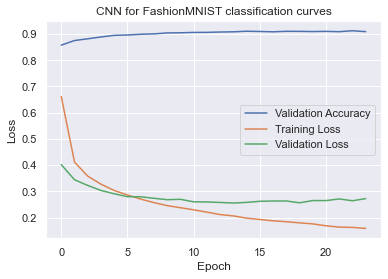

In [37]:
history  = best_net.history

plt.plot(history[:, ('valid_acc')], label='Validation Accuracy')
plt.plot(history[:, ('train_loss')], label='Training Loss')
plt.plot(history[:, ('valid_loss')], label='Validation Loss')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('CNN for FashionMNIST classification curves')
plt.savefig('curves_cnn.pdf')

## Confusion matrix

The final accuracy on the test set is:  0.9004


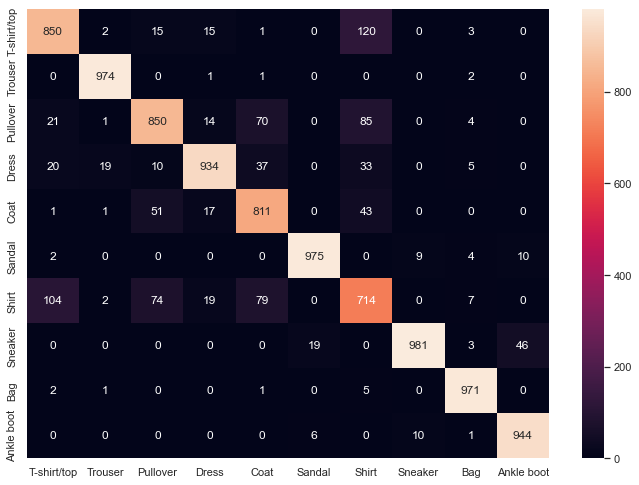

In [39]:
#test_set_array = np.expand_dims(test_set_array, 1) 
test_set_array = np.squeeze(test_set_array, 1) 
label_pred = best_net.predict(test_set_array)

print('The final accuracy on the test set is: ', accuracy_score(test_set_label, label_pred))

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(confusion_matrix(label_pred, test_set_label), annot = True, xticklabels = label_names, yticklabels = label_names, fmt = 'g')
plt.savefig('confusion_matrix.pdf')

## Misclassified samples

The misclassified samples are in total:  996
True:  Shirt
Predicted:  T-shirt/top


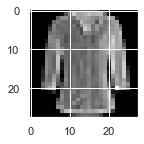

True:  Ankle boot
Predicted:  Sandal


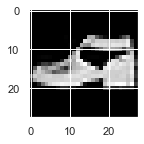

True:  Coat
Predicted:  Pullover


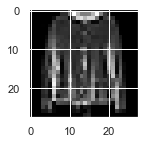

True:  Dress
Predicted:  Shirt


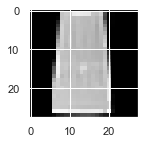

True:  Pullover
Predicted:  Shirt


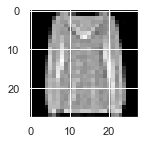

True:  Dress
Predicted:  Coat


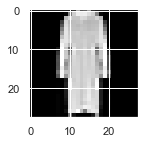

True:  Ankle boot
Predicted:  Sneaker


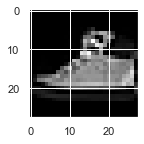

True:  Shirt
Predicted:  Pullover


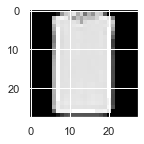

True:  Coat
Predicted:  Pullover


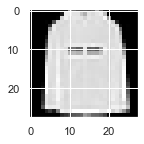

True:  Ankle boot
Predicted:  Sneaker


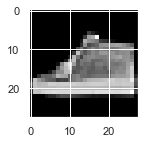

In [40]:
misclassified_indices = [i for i in range(len(label_pred)) if label_pred[i] != test_set_label[i]] 
sns.set(rc={'figure.figsize':(2,2)})

print('The misclassified samples are in total: ', len(misclassified_indices))
for i in range(10):
    ind = misclassified_indices[i]
    img = np.array(test_set_array[ind][0])
    print('True: ',label_names[int(test_set_label[ind])])
    print('Predicted: ',label_names[int(label_pred[ind])])
    plt.imshow(np.array(img), cmap = 'gist_gray')
    plt.show()

## Weights

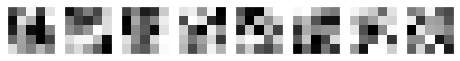

In [41]:
h1_w = best_net.module_.conv1.weight.data.cpu().numpy()

fig, ax = plt.subplots(1,8, figsize=(8, 8))

for i in range(8):
    ax[i].imshow( h1_w[i, 0, :, :], cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.savefig('weights_conv1.pdf')

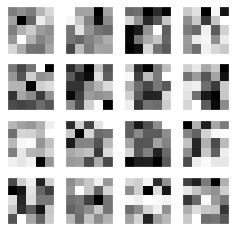

In [42]:
h2_w = best_net.module_.conv2.weight.data.cpu().numpy()

fig, ax = plt.subplots(4,4, figsize=(4, 4))
for j in range(4):
    for i in range(4):
        ax[j][i].imshow( h2_w[i, j, :, :], cmap='Greys')
        ax[j][i].set_xticks([])
        ax[j][i].set_yticks([])
plt.savefig('weights_conv2.pdf')

## Activations

In [43]:
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

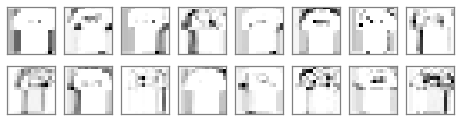

In [56]:
conv1 = best_net.module_.conv1.register_forward_hook(getActivation('conv1'))

x = train_dataset[1][0].cpu().unsqueeze(0).to(device)
layers = [best_net.module_.conv1, nn.ReLU(), best_net.module_.mpool2d]
for layer in layers:
    x = layer(x)
out_conv1 = x.squeeze(0).cpu().detach().numpy()

fig, ax = plt.subplots(2,8, figsize=(8, 2))
j=0
for a, filt in enumerate(out_conv1):
    if a<8:
        ax[0][a].grid(False)
        ax[0][a].imshow(filt, cmap='Greys')
        ax[0][a].set_xticks([])
        ax[0][a].set_yticks([])
        ax[0][a].spines['bottom'].set_color('0.5')
        ax[0][a].spines['top'].set_color('0.5')
        ax[0][a].spines['right'].set_color('0.5')
        ax[0][a].spines['left'].set_color('0.5')
    else: 
        ax[1][a-8].grid(False)
        ax[1][a-8].imshow(filt, cmap='Greys')
        ax[1][a-8].set_xticks([])
        ax[1][a-8].set_yticks([])
        ax[1][a-8].spines['bottom'].set_color('0.5')
        ax[1][a-8].spines['top'].set_color('0.5')
        ax[1][a-8].spines['right'].set_color('0.5')
        ax[1][a-8].spines['left'].set_color('0.5')


plt.savefig('receptive_field_conv1d.pdf')

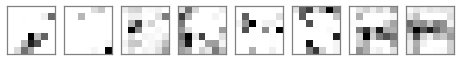

In [57]:
conv2 = best_net.module_.conv2.register_forward_hook(getActivation('conv2'))

x = train_dataset[1][0].cpu().unsqueeze(0).to(device)
layers = [best_net.module_.conv1, nn.ReLU(), best_net.module_.mpool2d, best_net.module_.dr2 ,best_net.module_.conv2, nn.ReLU(), best_net.module_.mpool2d]
for layer in layers:
    x = layer(x)
out_conv2 = x.squeeze(0).cpu().detach().numpy()

fig, ax = plt.subplots(1,8, figsize=(8, 2))
for i, filt in enumerate(out_conv2):
    ax[i].grid(False)
    ax[i].imshow(filt, cmap='Greys')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines['bottom'].set_color('0.5')
    ax[i].spines['top'].set_color('0.5')
    ax[i].spines['right'].set_color('0.5')
    ax[i].spines['left'].set_color('0.5')
plt.savefig('receptive_field_conv2d.pdf')